# Superpixel generation and groundtruth augmentation

This notebook allows to run the superpixel generation and groundtruth augmentation piece by piece.

*In Litterature*:
    
- start with 1500 and decrease by 80% at each iteration
- start with 10x the number of labelled pixels, end with the 10th of labelled pixels
- start with 5000 to 300, 30 levels

## Importing necessary libraries

In [2]:
from collections import Counter
from imutils import paths
from skimage import io
import argparse
import csv
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import os

1706


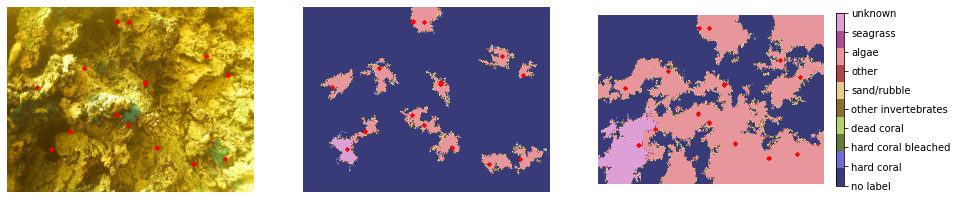

In [64]:
import random

classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

imagePaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/images")))
labelPaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/labels")))
label_dense = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/labels_dense")))
trainMasks = [s.replace('labels', 'masks_9x9') for s in labelPaths]

a=random.randrange(len(imagePaths))
print(a)
image = io.imread(imagePaths[a])
label = io.imread(labelPaths[a])
label_dense = io.imread(label_dense[a])
mask = io.imread(trainMasks[a])

fig, ax = plt.subplots(ncols=3, figsize=(15, 15))
ax[0].imshow(image)
ax[0].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20b', 10), vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cax = ax[2].imshow(label_dense, cmap = plt.cm.get_cmap('tab20b', 10), vmin=0, vmax=9)
ax[2].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.show()

(-0.5, 3999.5, 2999.5, -0.5)

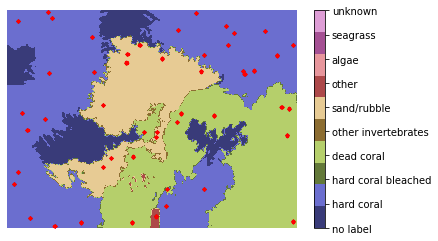

In [76]:
a = 6227
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

imagePaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/images")))
labelPaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/labels")))
label_dense = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/labels_dense")))
trainMasks = [s.replace('labels', 'masks_9x9') for s in labelPaths]

image = io.imread(imagePaths[a])
label = io.imread(labelPaths[a])
label_dense = io.imread(label_dense[a])
mask = io.imread(trainMasks[a])

cax = plt.imshow(label_dense, cmap = plt.cm.get_cmap('tab20b', 10), vmin=0, vmax=9)
plt.scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')
cbar = plt.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.axis('off')

## Configuration

In [4]:
# value of non-labeled pixels
DEFAULT_VALUE = int(255)

# number of max iterations
NL = int(30)

# number of superpixels in the first iteration
start_superpixels = int(500)

# number of superpixels in the last iteration
last_superpixels = int(200)

In [5]:
csv_sizes = []
reduction_factor = math.pow(float(last_superpixels) / start_superpixels, 1. / (NL - 1))
for level in range(NL):
    csv_sizes = csv_sizes + [int(round(start_superpixels * math.pow(reduction_factor, level)))]

## Which dataset chunk

In [6]:
dataset = '/data/jantina/Superpixels/Datasets/Test'

sparse_dir = os.path.join('/data/jantina/Superpixels/Test/sparse_GT')
out_dir = os.path.join('/data/jantina/Superpixels/Test/augmented_GT')
superpixels_dir = os.path.join('/data/jantina/Superpixels/Test/superpixels')

folders = ['test', 'train']

### Execute superpixel generation

In [7]:
size_sup_string = " "
for size in csv_sizes:
    size_sup_string = size_sup_string + str(size) + " "

%cd /data/jantina/Superpixels/
os.system("sh /home/jantina/CoralNet/Superpixels/generate_superpixels/generate_superpixels.sh " + dataset + size_sup_string)


/data/jantina/Superpixels
3 images total ...
On average, 0.916509 seconds needed ...
3 images total ...
On average, 0.657032 seconds needed ...
3 images total ...
On average, 0.919754 seconds needed ...
3 images total ...
On average, 0.668051 seconds needed ...
3 images total ...
On average, 0.911289 seconds needed ...
3 images total ...
On average, 0.655161 seconds needed ...
3 images total ...
On average, 0.903426 seconds needed ...
3 images total ...
On average, 0.658064 seconds needed ...
3 images total ...
On average, 0.905989 seconds needed ...
3 images total ...
On average, 0.660326 seconds needed ...
3 images total ...
On average, 0.919605 seconds needed ...
3 images total ...
On average, 0.65754 seconds needed ...
3 images total ...
On average, 0.928147 seconds needed ...
3 images total ...
On average, 0.652199 seconds needed ...
3 images total ...
On average, 1.23891 seconds needed ...
3 images total ...
On average, 1.10938 seconds needed ...
3 images total ...
On average, 1.

0

## Classes

In [8]:
class Superpixel:
    def __init__(self, maxlength=10000): #10000000
        self.lista_x = np.zeros([maxlength], dtype=np.int16)
        self.lista_y = np.zeros([maxlength], dtype=np.int16)
        self.lista_x[:]=-1
        self.lista_y[:]=-1
        self.index = 0

    def add(self, value_x, value_y):
        if self.index >= len(self.lista_x):
            #make it bigger
            new_size = len(self.lista_x)*10
            lista_x_new = np.zeros([new_size], dtype=np.int16)
            lista_y_new = np.zeros([new_size], dtype=np.int16)
            lista_x_new[:] = -1
            lista_y_new[:] = -1

            lista_x_new[:len(self.lista_x)] = self.lista_x
            lista_y_new[:len(self.lista_y)] = self.lista_y
            self.lista_x = lista_x_new
            self.lista_y = lista_y_new

        self.lista_x[self.index]=value_x
        self.lista_y[self.index]=value_y
        self.index += 1

    def clean(self):
        self.lista_x = self.lista_x[self.lista_x>=0]
        self.lista_y = self.lista_y[self.lista_y>=0]

In [9]:
def label_mayoria_x_y(superpixel, gt):
    '''Given a superpixel and a GT image, returns the label value of the superpixel'''
    
    # pixel label values of the superpixels
    pixel_values = gt[superpixel.lista_x.astype(int), superpixel.lista_y.astype(int)]
    # pixel label values of the superpixels excluding the default value
    values_labels = pixel_values[pixel_values < DEFAULT_VALUE]
    # returns the value which appears the most
    if len(values_labels) == 0:
        return DEFAULT_VALUE
    else:
        count = Counter(values_labels)
        return count.most_common()[0][0]

In [10]:
def image_superpixels_gt(csv_name, gt_name, n_superpixels):
    '''Given a csv file with segmentations (csv_name) and a sparse GT image (gt_name),
        returns Superpixel-augmented GT image'''
    
    print(gt_name)
    gt = cv2.imread(gt_name, 0)
    blank_image = np.zeros((gt.shape[0], gt.shape[1], 1), np.uint8)

    superpixels = {}

    for i in range(n_superpixels*2):
        superpixels[str(i)] = Superpixel()

    # for each csv segmentation file, creates the Superpixel class
    with open(csv_name, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        i = 0
        for row in spamreader:
            fila = row[0].split(',')
            fila_count = len(fila)
            for j in range(fila_count):
                superpixel_index = fila[j]
                # the pixel here is (i, j). (superpixel_index) is the segmentation which the pixel belongs to
                # add the pixel  to the Superpixel instance
                superpixels[superpixel_index].add(i, j)
            i = i + 1

    # for each superpixel, gets its label value and writes it into the image to return
    for index in range(len(superpixels)):
        superpixels[str(index)].clean()
        label_superpixel = label_mayoria_x_y(superpixels[str(index)], gt)
        blank_image[superpixels[str(index)].lista_x.astype(int), 
                    superpixels[str(index)].lista_y.astype(int)] = int(label_superpixel)

    return blank_image

In [11]:
%cd /data/jantina/Superpixels/

def generar_augmentedGT():
    for folder in folders:

        in_folder = os.path.join(sparse_dir, folder)
        out_folder = os.path.join(out_dir, folder)
        superpixels_folder = os.path.join(superpixels_dir, folder)

        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
            
        print(in_folder + '/*.' + 'png')
  
        for filename in glob.glob(in_folder + '/*.' + 'png'):
            gt_name = filename.split('/')[-1]
            gt_filename = os.path.join(out_folder, gt_name)
            # for each different segmentation generated
            for index in range(len(csv_sizes)):
                print(csv_sizes[index])

                csv_name = os.path.join(superpixels_folder, 'superpixels_' + str(csv_sizes[index]),
                                        gt_name.replace('.' + 'png', '') + '.csv')

                if index == 0:
                    # creates the first one (it has to be the more detailed one, the segmentation with more segments)
                    image_gt_new = image_superpixels_gt(csv_name, filename, csv_sizes[index])
                else:
                    # mask it with the less detailed segmentations in order to fill the areas with no valid labels
                    image_gt_new_low = image_superpixels_gt(csv_name, filename, csv_sizes[index])
                    image_gt_new[image_gt_new == DEFAULT_VALUE] = image_gt_new_low[image_gt_new == DEFAULT_VALUE]
                    print(image_gt_new.shape)
                # cv2.imwrite(gt_filename.replace(gt_name, gt_name.replace('.png', '_'+str(csv_sizes[index])+'.png')),image_gt_new)

            # out_dir
            cv2.imwrite(gt_filename, image_gt_new)

/data/jantina/Superpixels


## Generate augmented groundtruth

In [12]:
generar_augmentedGT()
print('[INFO] generation completed')

/data/jantina/Superpixels/Test/sparse_GT/test/*.png
500
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
484
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
469
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
455
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
441
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
427
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
414
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
401
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
388
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
376
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
365
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
353
/data/jantina/Superpixels/Test/sparse_GT/test/10A-Copy1.png
(1308, 2328, 1)
342


(3000, 4000, 1)
200
/data/jantina/Superpixels/Test/sparse_GT/test/2021-05-27-ASAN-B-T4 24-Copy1.0-A (P5270613).png
(3000, 4000, 1)
/data/jantina/Superpixels/Test/sparse_GT/train/*.png
500
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
484
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
469
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
455
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
441
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
427
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
414
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
401
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
388
/data/jantina/Superpixels/Test/sparse_GT/train/KY-M1GOPR0778-Copy1.png
(3000, 4000, 1)
376
/data/jan

(849, 584, 1)
250
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
242
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
234
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
227
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
220
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
213
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
206
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
200
/data/jantina/Superpixels/Test/sparse_GT/train/BH10_T1-005-Copy1.png
(849, 584, 1)
[INFO] generation completed
